# covid-19 India

## Goals
### A. Daily New Corona Cases Forecast
### B. Daily Deaths Prediction

The forecast of New corona cases in India will help in determining the magnitude of the coronavirus pandemic in coming days. Which will help the central and state governments to embrace for the future challenges and prepare for it in order to make forecast fail. 

Daily death prediction will also help the central and state governments to judge their health care system and the arrangements made to cure coronavirus effected people. This will lead the health care system to optimize better for future cases.  

## Final Results

In [192]:
covid_forecast

,New Cases,New Deaths
2020-06-12,10173,278
2020-06-13,10308,282
2020-06-14,10503,287
2020-06-15,10661,292
2020-06-16,10794,295
2020-06-17,10952,299
2020-06-18,11122,304
2020-06-19,11281,308
2020-06-20,11436,313
2020-06-21,11611,317


## Import Dataset and Libraries.  
##### source= [WHO](https://covid19.who.int/?gclid=EAIaIQobChMI2pGr-7rY6QIVgdeWCh2YPwsFEAAYASAAEgImqPD_BwE)
In this section I would import the libraries and dataset to be used in this project

In [222]:
#general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#to build forecast
from datetime import datetime
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

#to build the model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split


#to evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tools.eval_measures import rmse

pd.plotting.register_matplotlib_converters()

In [254]:
covid_india = pd.read_csv('covidindia.csv',index_col = 'Date', parse_dates=True)

In [255]:
#checking the index to make sure that dates are of datetime type
covid_india.index

DatetimeIndex(['2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-08',
               ...
               '2020-06-03', '2020-06-04', '2020-06-05', '2020-06-06',
               '2020-06-07', '2020-06-08', '2020-06-09', '2020-06-10',
               '2020-06-11', '2020-06-12'],
              dtype='datetime64[ns]', name='Date', length=135, freq=None)

In [256]:
#need to change the frequency(freq) from none to daily(d)
covid_india.index.freq = 'D'
covid_india.index

DatetimeIndex(['2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-08',
               ...
               '2020-06-03', '2020-06-04', '2020-06-05', '2020-06-06',
               '2020-06-07', '2020-06-08', '2020-06-09', '2020-06-10',
               '2020-06-11', '2020-06-12'],
              dtype='datetime64[ns]', name='Date', length=135, freq='D')

##### Lets check the head of the data

In [211]:
covid_india.head()

,New Cases,New Deaths
Date,,
2020-01-30,1,0
2020-01-31,0,0
2020-02-01,0,0
2020-02-02,1,0
2020-02-03,1,0


## Data Visualization

##### New Cases and New Deaths 

Text(0.5, 1.0, 'Date VS New cases and Deaths')

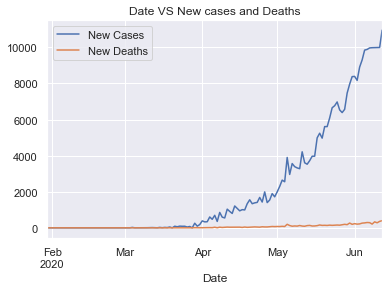

In [257]:
covid_india[['New Cases','New Deaths']].plot()
plt.title('Date VS New cases and Deaths')

##### Date wise corona daily cases and daily deaths in India

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Figure size 432x288 with 0 Axes>

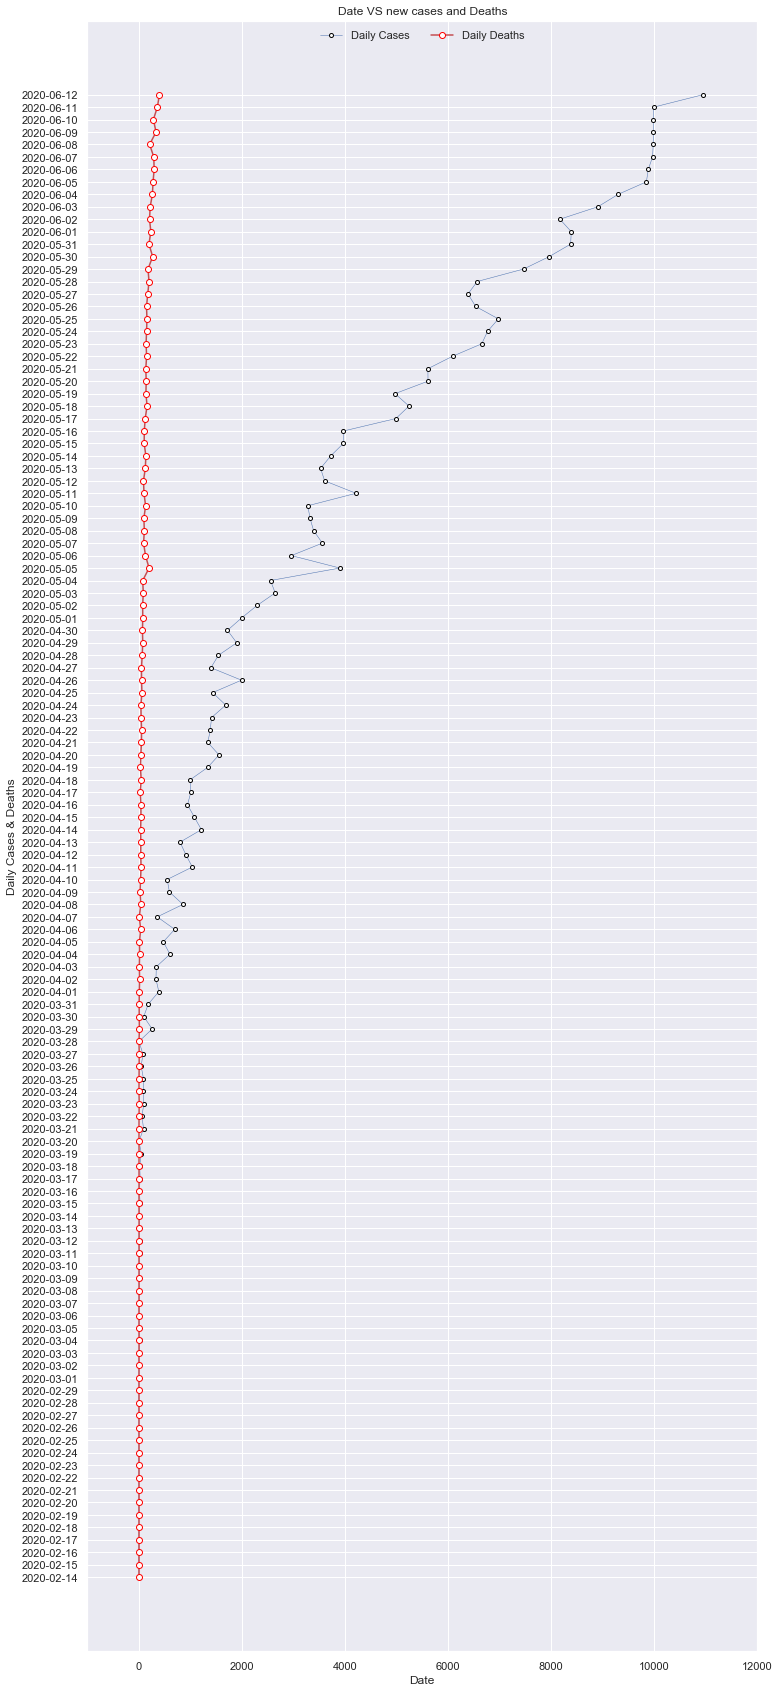

In [258]:
covid = pd.read_csv('covidindia.csv')
fig = plt.figure()
plt.figure(figsize=(12,30))
ax=plt.axes()
plt.plot(covid['New Cases'][15:135], covid['Date'][15:135],'-ob',label='Daily Cases',markersize=4, linewidth=0.5,markerfacecolor='white',markeredgecolor='black');
plt.plot(covid['New Deaths'][15:135], covid['Date'][15:135],'-or',label='Daily Deaths',markerfacecolor='white',markeredgecolor='red');
plt.xlim(-1000,12000)
plt.title('Date VS new cases and Deaths')
plt.xlabel('Date')
plt.ylabel("Daily Cases & Deaths")
plt.legend()
ax.legend(frameon=False, loc='upper center', ncol=2)
sns.set()
#plt.axis('equal')

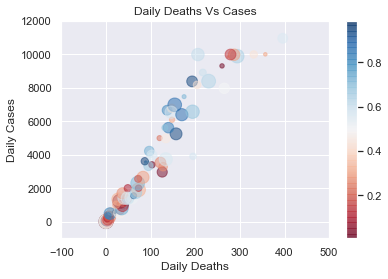

In [259]:
rng = np.random.RandomState(0)
x = covid['New Deaths']
y = covid['New Cases']
plt.xlabel('Daily Deaths')
plt.ylabel('Daily Cases')
colors = rng.rand(135)
sizes = 200 * rng.rand(1000)
plt.scatter(x, y, c=colors, s=sizes, alpha=0.5,cmap='RdBu')
plt.title('Daily Deaths Vs Cases')
plt.colorbar();
plt.xlim(-100,500)
plt.ylim(-1000,12000)
sns.set()

## A. Daily New Corona Cases Forecast

In [260]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

### Checking the time series is stationary or non-stationary
To determine if an incoming time series is stationary, let's write a function that performs the augmented Dickey-Fuller Test.

In [261]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [262]:
adf_test(covid_india['New Cases'])

Augmented Dickey-Fuller Test: 
ADF test statistic        4.103489
p-value                   1.000000
# lags used              11.000000
# observations          123.000000
critical value (1%)      -3.484667
critical value (5%)      -2.885340
critical value (10%)     -2.579463
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


As the data is **non-stationary**, which is confirmed by the above Augmented Dicky Fuller test, we will have to introducte **Differencing** which will make the data stationary for forecast. 

In [320]:
from statsmodels.tsa.statespace.tools import diff
covid_india['diff-1'] = diff(covid_india['New Cases'],k_diff=1)
adf_test(covid_india['diff-1'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.737856
p-value                   0.836699
# lags used              13.000000
# observations          120.000000
critical value (1%)      -3.486056
critical value (5%)      -2.885943
critical value (10%)     -2.579785
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


So by **differencing at 1** we get the data **stationary**.

### Checking the seasonality of the time series by Seasonal Decompose method

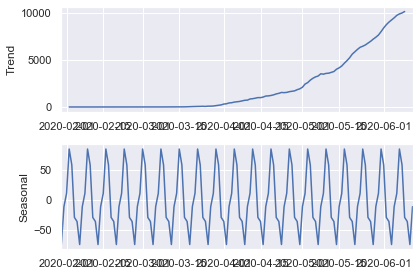

In [264]:
SD = seasonal_decompose(covid_india['New Cases'], model = 'add')
SD.plot(observed=False,seasonal=True,trend=True,resid=False);

So there is a seasonality componant in the data. As the data is daily we will take **m=7**

##### As the data has seasonality we will use SARIMA to get the forecast

### Getting parameters p,d,q and P,D,Q for SARIMA MODEL
We will use auto_arima function from pmdarima library to get the parameters and later we will confirm p and q by using acf and pacf plots

In [270]:
auto_arima(covid_india['New Cases'],seasonal=True,m=7,trace=True).summary()

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(1,0,1,7) [intercept=True]; AIC=1884.757, BIC=1907.880, Time=1.963 seconds
Fit ARIMA(0,2,0)x(0,0,0,7) [intercept=True]; AIC=2017.286, BIC=2023.066, Time=0.052 seconds
Fit ARIMA(1,2,0)x(1,0,0,7) [intercept=True]; AIC=1945.841, BIC=1957.403, Time=0.177 seconds
Fit ARIMA(0,2,1)x(0,0,1,7) [intercept=True]; AIC=1895.522, BIC=1907.084, Time=0.312 seconds
Near non-invertible roots for order (0, 2, 1)(0, 0, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,2,0)x(0,0,0,7) [intercept=False]; AIC=2015.317, BIC=2018.208, Time=0.007 seconds
Fit ARIMA(2,2,2)x(0,0,1,7) [intercept=True]; AIC=1882.180, BIC=1902.412, Time=0.834 seconds
Near non-invertible roots for order (2, 2, 2)(0, 0, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,2,2)x(1,0,0,7) [intercept=True]; AIC=1882.126, BIC=1902.359, Time=2.148 seco

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  135
Model:             SARIMAX(1, 2, 2)x(1, 0, [1], 7)   Log Likelihood                -932.250
Date:                             Sat, 13 Jun 2020   AIC                           1878.500
Time:                                     10:01:34   BIC                           1898.732
Sample:                                          0   HQIC                          1886.722
                                             - 135                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4577      5.805      0.251      0.802      -9.920      12.835
ar.L1          0.5774      0.065      8.914      0.000       0.450       0.704
ma.L1         -1.9619      0.071    -27.635      0.000      -2.101      -1.823
ma.L2          0.9901      0.072     13.827      0.000       0.850       1.130
ar.S.L7       -0.9979      7.419     -0.135      0.893     -15.539      13.543
ma.S.L7        0.9965      8.352      0.119      0.905     -15.373      17.366
sigma2      6.783e+04   5.94e+04      1.141      0.254   -4.87e+04    1.84e+05
===================================================================================
Ljung-Box (Q):                       81.06   Jarque-Bera (JB):               270.11
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             244.07   Skew:                             1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.52e+14. Standard errors may be unstable.
"""

By running the auto_arima function we got the following **parameters**:
* **Order** = (1, 2, 2)
* **Seasonal_Order** = (2, 0, [1], 7)

Lets Now confirm p and q component values through acf and pacf plots

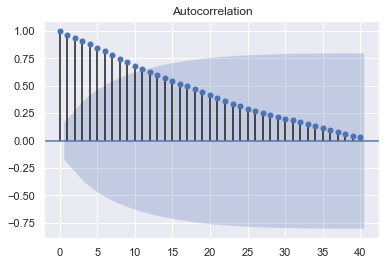

In [267]:
plot_acf(covid_india['New Cases'],lags=40);

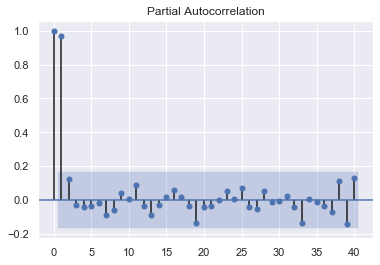

In [268]:
plot_pacf(covid_india['New Cases'],lags=40);

It is clear from the above models that the p value is 3 (pacf) and q value is 3 (acf)

## Spliting the data into train/test set
Steps:
* Split known data into a training set of records on which to fit the model
* Use the remaining records for testing, to evaluate the model
* Fit the model again on the full set of records
* Predict a future set of values using the model

In [269]:
train = covid_india.iloc[:114]
test = covid_india.iloc[114:]

In [271]:
model_test=SARIMAX(train['New Cases'],order = (1,2,2),seasonal_order=(1,0,[1],7))

In [272]:
fit_test=model_test.fit()

In [273]:
start = len(train)
end = len(train) + len(test) - 1

In [274]:
forecast_test = fit_test.predict(start = start, end = end, typ = 'levels').rename("forecast")

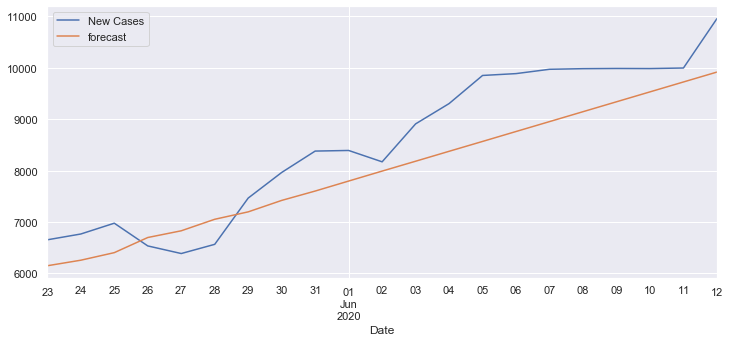

In [275]:
test['New Cases'].plot(figsize=(12,5),legend=True)
forecast_test.plot(legend=True)

### Evaluate the Model
by Root mean square error


In [276]:
error = rmse(test['New Cases'], forecast_test)
print(f'ARIMA(1,2,2) RMSE Error: {error:11.10}')

ARIMA(1,2,2) RMSE Error: 706.4539877


In [277]:
test['New Cases'].mean()

8528.0

So the RMSE value is in **1:12 ratio** with the mean, which is pretty good. Now lets forecast for the future dates.

## Forecasting
Now we're ready to train our best model on the greatest amount of data, and fit it to future dates.

In [278]:
model_final=SARIMAX(covid_india['New Cases'],order = (1,2,2),seasonal_order=(1,0,[1],7))

In [279]:
fit_final = model_final.fit()

In [281]:
forecast_final = fit_final.predict(start = len(covid_india), end = len(covid_india) +11, typ = 'levels').rename("Forecasted new cases till 24th June")

Text(0, 0.5, 'New Cases')

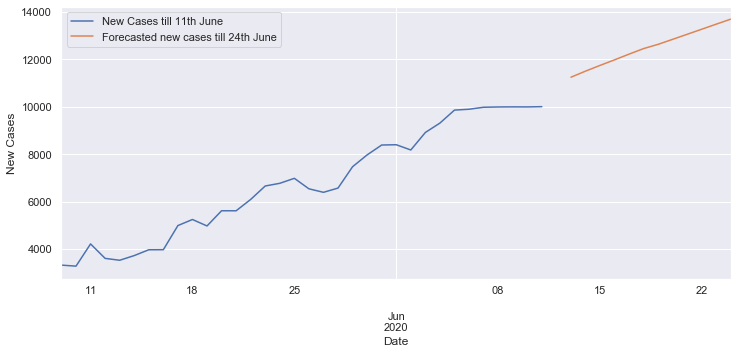

In [282]:
covid_india['New Cases'][100:134].plot(figsize=(12,5),legend=True, label = 'New Cases till 11th June')
forecast_final.plot(legend=True)
plt.ylabel('New Cases')

#### Date wise New Corona Cases in the India from 13th June to 24th June

In [283]:
forecast_final.astype(int)

2020-06-13    11235
2020-06-14    11491
2020-06-15    11734
2020-06-16    11968
2020-06-17    12210
2020-06-18    12443
2020-06-19    12623
2020-06-20    12834
2020-06-21    13047
2020-06-22    13261
2020-06-23    13475
2020-06-24    13686
Freq: D, Name: Forecasted new cases till 24th June, dtype: int32

In [284]:
covid_forecast = pd.DataFrame(forecast_final.astype(int).rename('New Cases'))

In [285]:
covid_forecast

,New Cases
2020-06-13,11235
2020-06-14,11491
2020-06-15,11734
2020-06-16,11968
2020-06-17,12210
2020-06-18,12443
2020-06-19,12623
2020-06-20,12834
2020-06-21,13047
2020-06-22,13261


forecasting through facebook prophet library

In [286]:
from fbprophet import Prophet

In [287]:
df_covid = pd.read_csv('covidindia.csv')

In [288]:
df_covid.drop('New Deaths',axis =1,inplace=True)

In [289]:
df_covid.columns =['ds','y']

In [290]:
df_covid['ds']=pd.to_datetime(df_covid['ds'])

In [291]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(df_covid)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [292]:
future = m.make_future_dataframe(periods=12,freq = 'D')

In [293]:
forecast = m.predict(future)

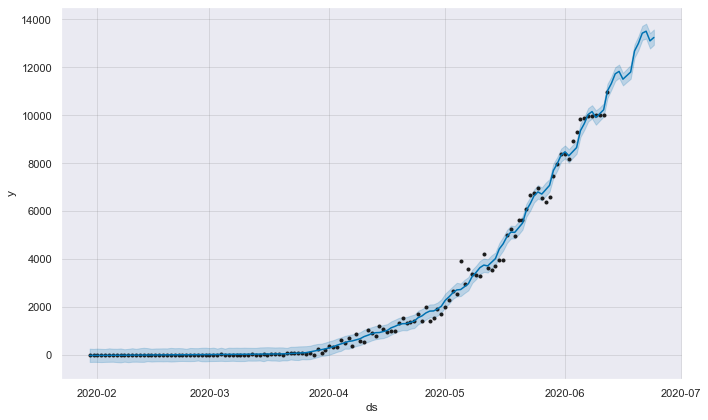

In [294]:
m.plot(forecast);

In [295]:
forecast[['ds','yhat_lower','yhat_upper','yhat']].tail(12)

,ds,yhat_lower,yhat_upper,yhat
135,2020-06-13,11060.442188,11603.644174,11319.098163
136,2020-06-14,11425.848857,11997.824960,11722.393922
137,2020-06-15,11553.080335,12108.318093,11822.936641
138,2020-06-16,11238.530275,11759.675580,11498.644553
139,2020-06-17,11379.688073,11925.685803,11650.811883
140,2020-06-18,11515.267841,12087.296460,11797.217479
141,2020-06-19,12403.206985,12952.659089,12674.895340
142,2020-06-20,12712.913137,13293.862845,12991.532009
143,2020-06-21,13136.166084,13722.221415,13418.612908
144,2020-06-22,13193.229086,13815.132968,13499.056502


As we can see from the graph that the fb prophet library is over predicting for future dates, so we will consider SARIMA forecasting only.

# B. Daily Deaths prediction

Implementing linear regression to predict daily deaths

In [296]:
lr = LinearRegression()

### Spliting the data into train/test set
Steps:
* Split known data into a training set and test set on random basis using train test spilt
* Fit the model on training set and test it on test set.
* Predict a future set of values using the model

In [297]:
covid_india.columns

Index(['New Cases', 'New Deaths'], dtype='object')

In [304]:
X= covid_india[['New Cases']]
y= covid_india[['New Deaths']]

In [305]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=102)

In [306]:
model1=lr.fit(X_train,y_train)

In [307]:
y_lr=lr.predict(X_test)

In [308]:
rmse = np.sqrt(mean_squared_error(y_test,y_lr))
r2 = (r2_score(y_test,y_lr))
print(rmse)
print(r2)

14.57468506914062
0.9747919657333521


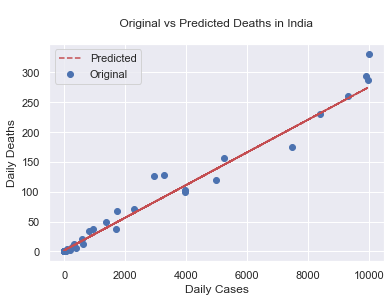

In [315]:
plt.scatter(X_test,y_test,label = "Original")
plt.plot(X_test,y_lr,'--r',label = "Predicted")
plt.legend()
plt.xlabel('Daily Cases')
plt.ylabel('Daily Deaths')
plt.title('\n Original vs Predicted Deaths in India \n')
sns.set()

Implementing **ridge regression** to predict daily deaths

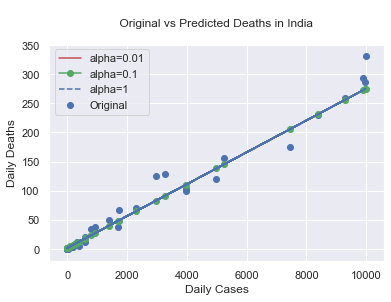

In [317]:
model_r1 = Ridge(alpha=0.01)
model_r1.fit(X_train,y_train)
model_r2= Ridge(alpha=0.1)
model_r2.fit(X_train,y_train)
model_r3= Ridge(alpha=1)
model_r3.fit(X_train,y_train)

#plotting all the models
plt.plot(X_test,model_r1.predict(X_test),'r',label='alpha=0.01')
plt.plot(X_test,model_r2.predict(X_test),'-og',label='alpha=0.1')   
plt.plot(X_test,model_r3.predict(X_test),'--b',label='alpha=1')   
plt.legend()
plt.scatter(X_test,y_test,label = 'Original')
plt.legend()
plt.xlabel('Daily Cases')
plt.ylabel('Daily Deaths')
plt.title('\n Original vs Predicted Deaths in India \n')
sns.set()

In [311]:
print("Train and Test set score")

for i in [model1,model_r1,model_r2,model_r3]:
    x= round(i.score(X_train,y_train)*100)
    y=round(i.score(X_test,y_test)*100)
    print(f"{i}={x}"" %")
    print(f"{i}={y}"" %\n")
    

Train and Test set score
LinearRegression()=93.0 %
LinearRegression()=97.0 %

Ridge(alpha=0.01)=93.0 %
Ridge(alpha=0.01)=97.0 %

Ridge(alpha=0.1)=93.0 %
Ridge(alpha=0.1)=97.0 %

Ridge(alpha=1)=93.0 %
Ridge(alpha=1)=97.0 %



As it is evident from the above scores that using linearregression or Ridge regression will give **similar results** so here I will prefer linear regression for building my model. 

In [312]:
covid_forecast['New Deaths'] =  lr.predict(covid_forecast).astype(int)

## Final Results for the next 12 Days

In [313]:
covid_forecast

,New Cases,New Deaths
2020-06-13,11235,309
2020-06-14,11491,316
2020-06-15,11734,322
2020-06-16,11968,329
2020-06-17,12210,335
2020-06-18,12443,342
2020-06-19,12623,347
2020-06-20,12834,352
2020-06-21,13047,358
2020-06-22,13261,364
